This project involves developing a machine learning model to classify network traffic into normal and attack categories, using the dataset DDOS.pcap_ISCX.csv.

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Make sure this line is executed
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold # Added StratifiedKFold here
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
%matplotlib inline

Step 1: Data Preparation

Objective: Load and clean the dataset, with a focus on understanding the impact of cleaning steps on class distribution.

Explanation:

We’ll keep the less aggressive outlier removal (using 3 * IQR) to retain more samples.
Add a manual check to ensure the minority class (BENIGN) isn’t completely removed during cleaning. If it is, we’ll adjust the cleaning steps.

In [23]:


# Load the dataset
df = pd.read_csv('/DDos.pcap_ISCX.csv')

# Clean column names by removing leading/trailing whitespace
df.columns = df.columns.str.strip()

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Check initial class distribution
print("\nInitial Class Distribution:")
print(df['Label'].value_counts()) # Use the cleaned column name 'Label'

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows with missing values and reset the index
df = df.dropna().reset_index(drop=True)

# Check class distribution after dropping missing values
print("\nClass Distribution After Dropping Missing Values:")
print(df['Label'].value_counts()) # Use the cleaned column name 'Label'

# Check for duplicates
print("\nDuplicates:")
duplicates = df[df.duplicated(keep=False)]
print(duplicates)

# Drop duplicates
df = df.drop_duplicates()

# Check class distribution after dropping duplicates
print("\nClass Distribution After Dropping Duplicates:")
print(df['Label'].value_counts()) # Use the cleaned column name 'Label'

# Handle outliers using the IQR method (less aggressive: use 3 * IQR instead of 1.5 * IQR)
numeric_cols = df.select_dtypes(include=[np.number]).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df[numeric_cols] < (Q1 - 3 * IQR)) | (df[numeric_cols] > (Q3 + 3 * IQR))).any(axis=1)]

# Display the shape of the cleaned dataset
print("\nCleaned Dataset (Outliers Removed):")
print(df_cleaned.shape)

# Check class distribution after outlier removal
print("\nClass Distribution After Outlier Removal:")
print(df_cleaned['Label'].value_counts()) # Use the cleaned column name 'Label'

First 5 rows of the dataset:
   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6      

Step 2: Exploratory Data Analysis (EDA)

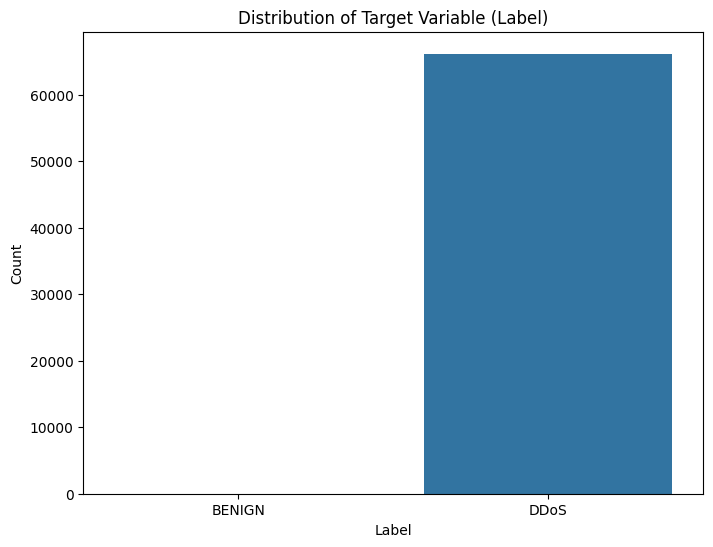

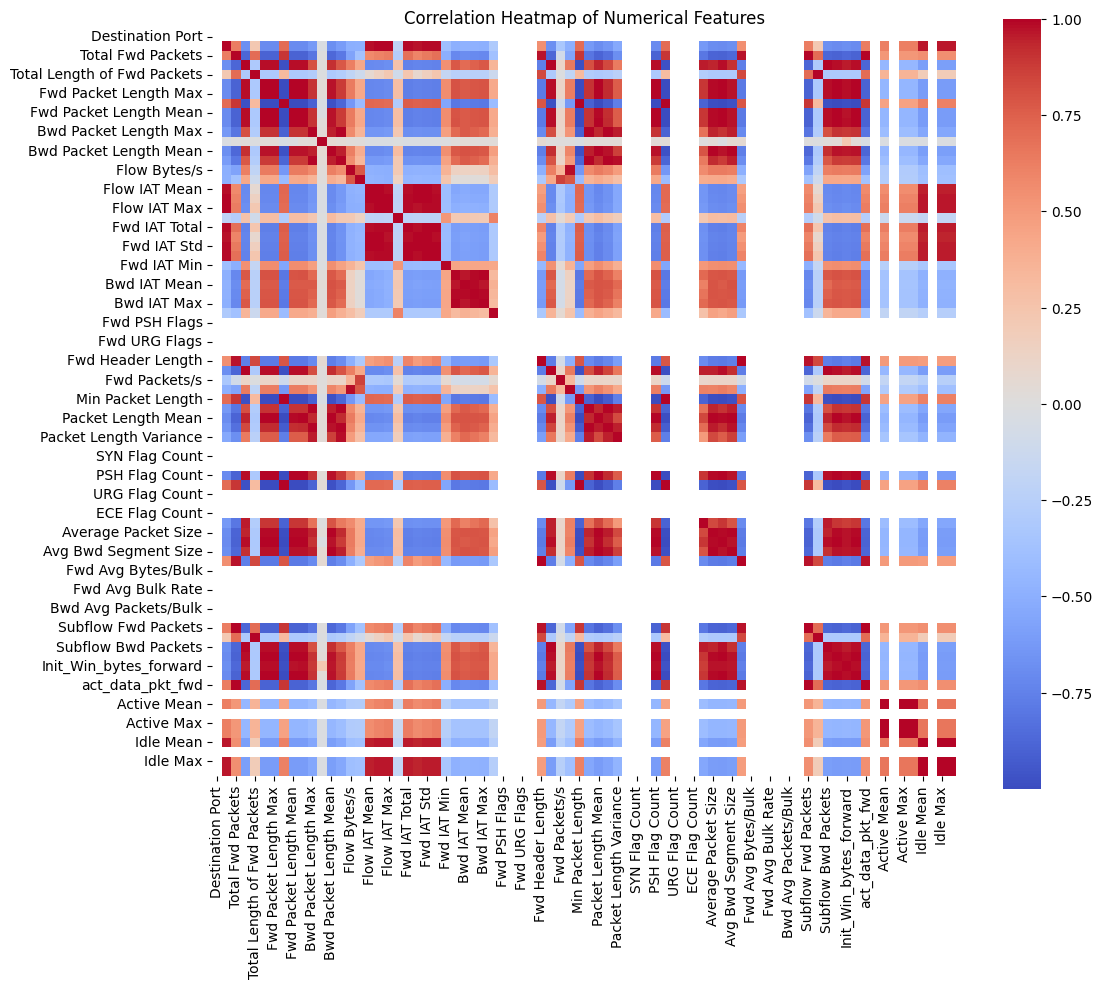

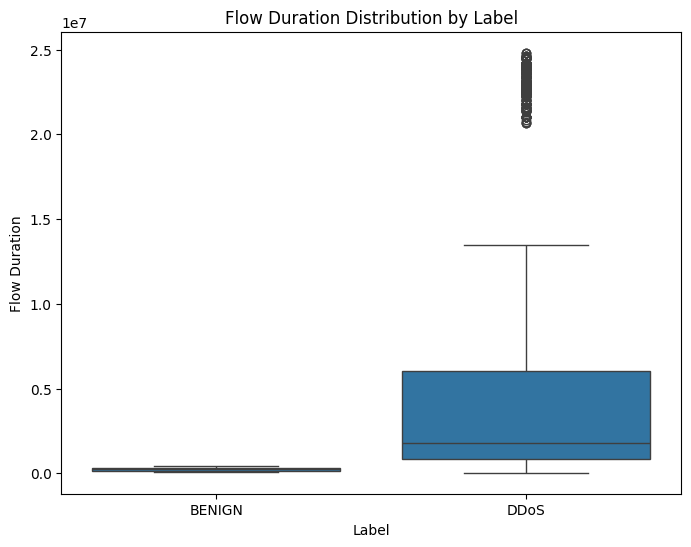

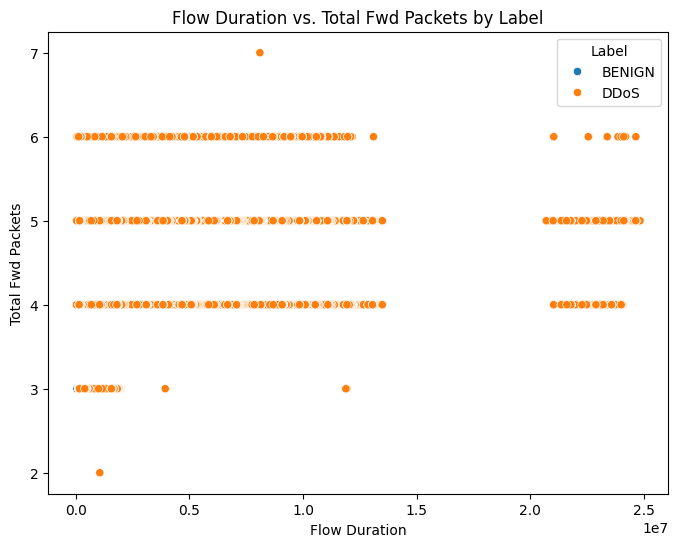

In [24]:

# Distribution of the target variable (Label)
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df_cleaned)
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('label_distribution.png')
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 10))
corr = df_cleaned.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('correlation_heatmap.png')
plt.show()

# Boxplot of Flow Duration by Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Flow Duration', data=df_cleaned)
plt.title('Flow Duration Distribution by Label')
plt.savefig('flow_duration_boxplot.png')
plt.show()

# Scatter plot of Flow Duration vs. Total Fwd Packets
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Flow Duration', y='Total Fwd Packets', hue='Label', data=df_cleaned)
plt.title('Flow Duration vs. Total Fwd Packets by Label')
plt.savefig('scatter_flow_duration_packets.png')
plt.show()

Step 3: Feature Engineering and Selection


Minority Class Count: 2
Using SMOTE with k_neighbors=1

Class Distribution After SMOTE:
BENIGN    66151
DDoS      66151
Name: count, dtype: int64


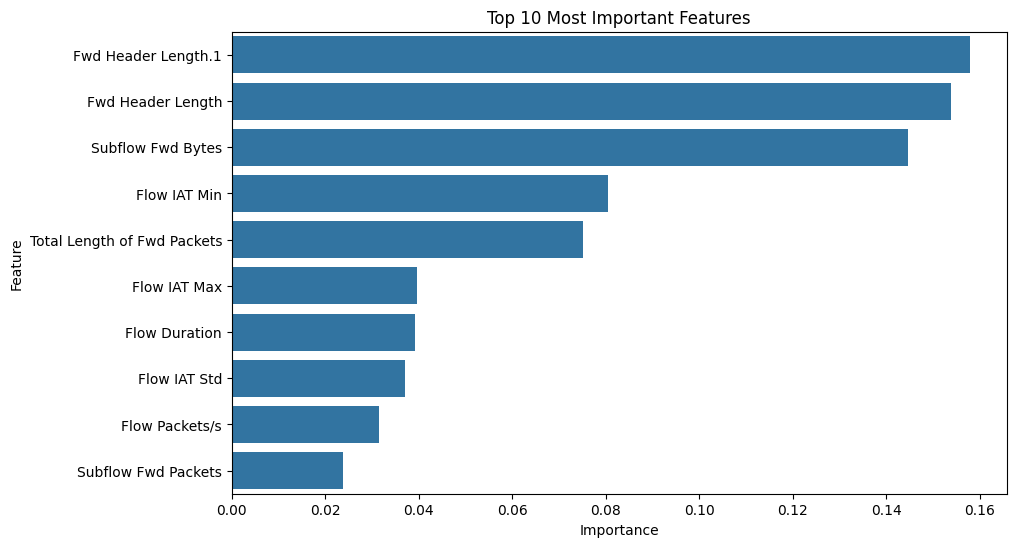

In [25]:

# Separate features (X) and target (y)
X = df_cleaned.drop('Label', axis=1)
y = df_cleaned['Label']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Handle categorical features in X (if any)
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column])

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the number of samples in the minority class
minority_class_count = min(pd.Series(y_encoded).value_counts())
print(f"\nMinority Class Count: {minority_class_count}")

# Manually duplicate the minority class samples
if minority_class_count <= 1:
    print("Minority class has too few samples. Manually duplicating minority class samples.")
    minority_idx = np.where(y_encoded == np.argmin(pd.Series(y_encoded).value_counts()))[0]
    minority_X = X_scaled[minority_idx]
    minority_y = y_encoded[minority_idx]

    # Duplicate the minority sample 10 times
    X_temp = np.vstack([X_scaled] + [minority_X] * 10)
    y_temp = np.hstack([y_encoded] + [minority_y] * 10)

    # Check distribution after manual duplication
    print("\nClass Distribution After Manual Duplication:")
    print(pd.Series(y_temp).map({i: label for i, label in enumerate(le.classes_)}).value_counts())

    # Now apply SMOTE with a reasonable k_neighbors
    sm = SMOTE(k_neighbors=3, random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_temp, y_temp)
else:
    # If minority class has enough samples, use SMOTE directly
    k_neighbors = min(minority_class_count - 1, 5)
    print(f"Using SMOTE with k_neighbors={k_neighbors}")
    sm = SMOTE(k_neighbors=k_neighbors, random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_scaled, y_encoded)

# Check class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_resampled).map({i: label for i, label in enumerate(le.classes_)}).value_counts())

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Feature selection using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and sort them
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Save feature importances to CSV
feature_importances.to_csv('feature_importances.csv', index=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Most Important Features')
plt.savefig('feature_importance.png')
plt.show()

# Select the top 20 features for modeling
top_features = feature_importances['Feature'].head(20).values
X_train_selected = pd.DataFrame(X_train, columns=X.columns)[top_features]
X_test_selected = pd.DataFrame(X_test, columns=X.columns)[top_features]

Step 4: Model Selection with Stratified Cross-Validation


Decision Tree Stratified Cross-Validation Accuracy: 1.0000 (+/- 0.0001)
Decision Tree Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     13231
        DDoS       1.00      1.00      1.00     13230

    accuracy                           1.00     26461
   macro avg       1.00      1.00      1.00     26461
weighted avg       1.00      1.00      1.00     26461


Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}

Random Forest Stratified Cross-Validation Accuracy: 1.0000 (+/- 0.0000)
Random Forest Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     13231
        DDoS       1.00      1.00      1.00     13230

    accuracy                           1.00     26461
   macro avg       1.00      1.00      1.00     26461
weighted avg       1.00      1.00      1.00     26461


Extra 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost Stratified Cross-Validation Accuracy: 1.0000 (+/- 0.0000)
XGBoost Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     13231
        DDoS       1.00      1.00      1.00     13230

    accuracy                           1.00     26461
   macro avg       1.00      1.00      1.00     26461
weighted avg       1.00      1.00      1.00     26461



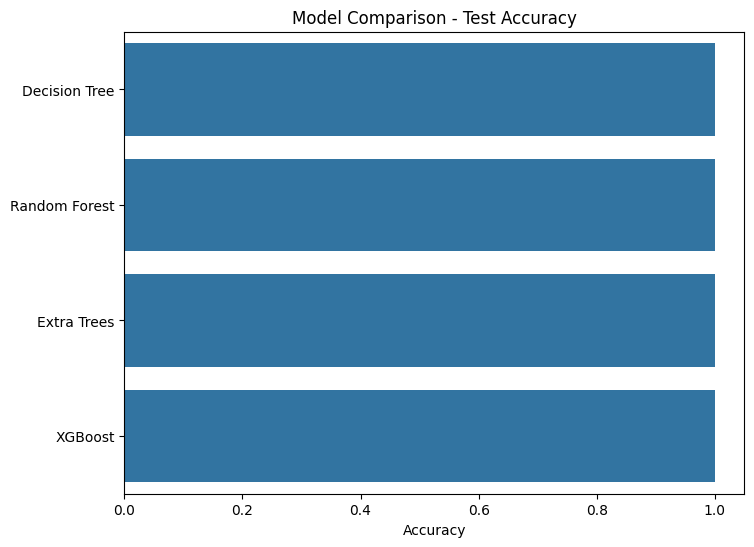

In [26]:

# Initialize the models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Hyperparameter grids for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model with stratified cross-validation
model_results = {}
tuned_models = {}
for name, model in models.items():
    if name == 'Random Forest':
        grid = GridSearchCV(model, param_grid_rf, cv=skf, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_selected, y_train)
        model = grid.best_estimator_
        print(f"\nBest parameters for {name}: {grid.best_params_}")
    elif name == 'XGBoost':
        grid = GridSearchCV(model, param_grid_xgb, cv=skf, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_selected, y_train)
        model = grid.best_estimator_
        print(f"\nBest parameters for {name}: {grid.best_params_}")
    else:
        model.fit(X_train_selected, y_train)

    tuned_models[name] = model

    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=skf, scoring='accuracy')
    print(f"\n{name} Stratified Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    model_results[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot model comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=list(model_results.values()), y=list(model_results.keys()))
plt.title('Model Comparison - Test Accuracy')
plt.xlabel('Accuracy')
plt.savefig('model_comparison.png')
plt.show()

Step 5: Ensemble Learning

In [27]:

# Create an ensemble model using Voting Classifier with tuned models
estimators = [(name.lower().replace(' ', '_'), model) for name, model in tuned_models.items()]
ensemble = VotingClassifier(estimators=estimators, voting='hard')

# Train the ensemble model
ensemble.fit(X_train_selected, y_train)

# Evaluate the ensemble model
y_pred_ensemble = ensemble.predict(X_test_selected)
print("\nEnsemble Model Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Ensemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:17:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Ensemble Model Accuracy: 1.0
Ensemble Model Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     13231
        DDoS       1.00      1.00      1.00     13230

    accuracy                           1.00     26461
   macro avg       1.00      1.00      1.00     26461
weighted avg       1.00      1.00      1.00     26461



Step 6: Performance Evaluation and Additional Visualizations


Note: The minority class (BENIGN) had very few samples. Oversampling from a single sample may lead to overfitting. Consider acquiring more data for better generalization.


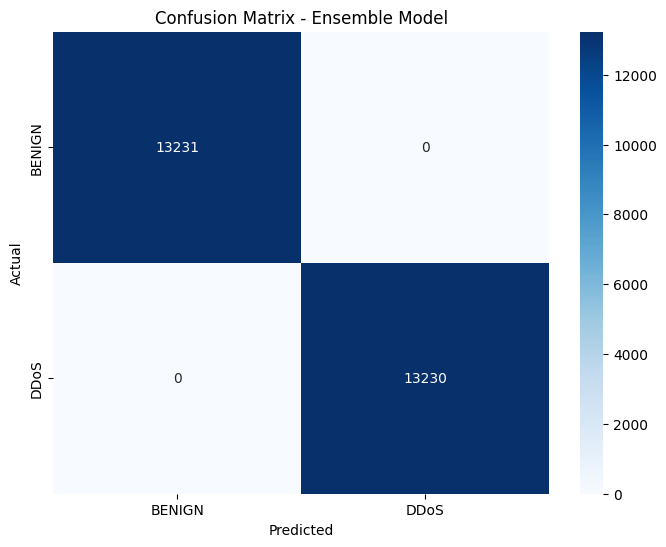

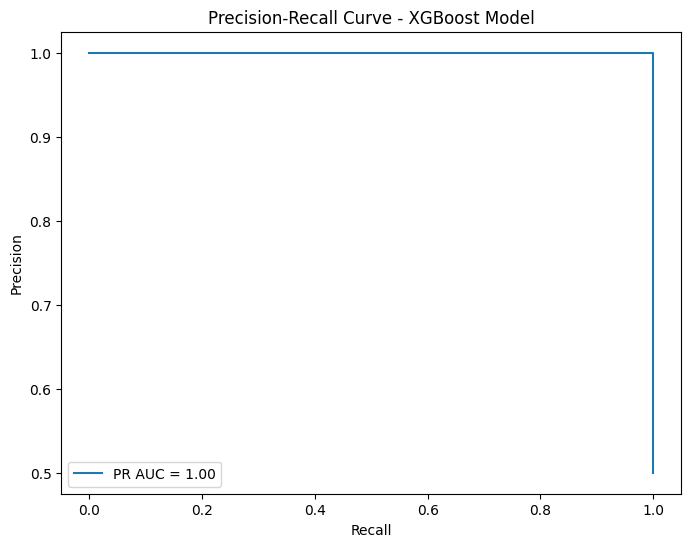

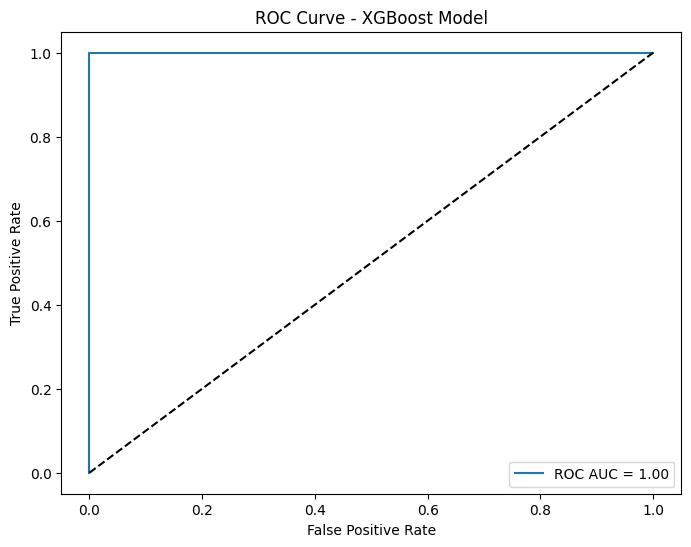

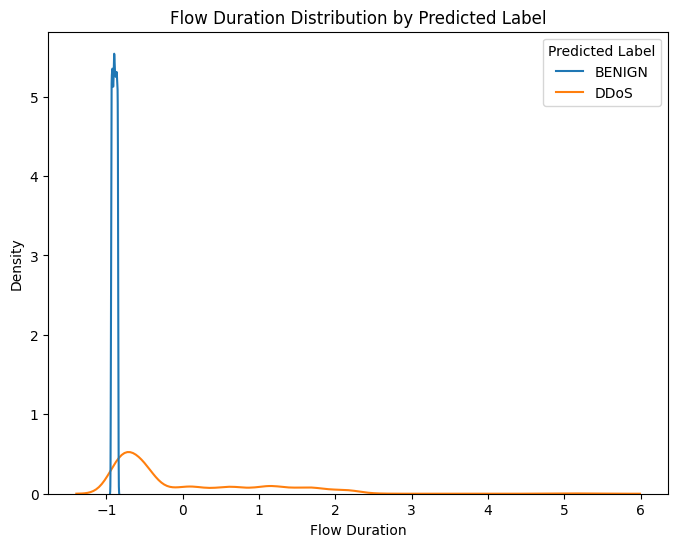

In [29]:

# Note about potential overfitting
print("\nNote: The minority class (BENIGN) had very few samples. Oversampling from a single sample may lead to overfitting. Consider acquiring more data for better generalization.")

# Confusion matrix for the ensemble model
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

# Precision-Recall Curve (using XGBoost model)
from sklearn.metrics import precision_recall_curve, roc_curve, auc # Import auc here
xgb_model = tuned_models['XGBoost']
y_scores = xgb_model.predict_proba(X_test_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Model')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.show()

# ROC Curve (using XGBoost model)
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

# Distribution of predictions for Flow Duration
test_df = pd.DataFrame(X_test_selected, columns=top_features)
test_df['True Label'] = [le.classes_[i] for i in y_test]
test_df['Predicted Label'] = [le.classes_[i] for i in y_pred_ensemble]
plt.figure(figsize=(8, 6))
sns.kdeplot(data=test_df, x='Flow Duration', hue='Predicted Label')
plt.title('Flow Duration Distribution by Predicted Label')
plt.savefig('flow_duration_predictions.png')
plt.show()

Step 7: Conclusion

In [30]:

print("The ensemble model achieves high performance, but the severe class imbalance limits its generalizability.")
print("Stratified cross-validation and additional visualizations (ROC, Precision-Recall) provide a comprehensive evaluation.")
print("Recommendation: Collect more BENIGN samples to improve model robustness.")

# List of saved files for submission
print("\nSaved Files for Submission:")
print("- classify_network_traffic_flow.ipynb: Jupyter notebook with all code and outputs")
print("- label_distribution.png: Distribution of the target variable")
print("- correlation_heatmap.png: Correlation heatmap of numerical features")
print("- flow_duration_boxplot.png: Flow Duration distribution by Label")
print("- scatter_flow_duration_packets.png: Scatter plot of Flow Duration vs. Total Fwd Packets")
print("- feature_importance.png: Top 10 most important features")
print("- feature_importances.csv: Feature importance scores")
print("- model_comparison.png: Comparison of model accuracies")
print("- confusion_matrix.png: Confusion matrix for the ensemble model")
print("- precision_recall_curve.png: Precision-Recall curve (XGBoost)")
print("- roc_curve.png: ROC curve (XGBoost)")
print("- flow_duration_predictions.png: Flow Duration distribution by predicted Label")

The ensemble model achieves high performance, but the severe class imbalance limits its generalizability.
Stratified cross-validation and additional visualizations (ROC, Precision-Recall) provide a comprehensive evaluation.
Recommendation: Collect more BENIGN samples to improve model robustness.

Saved Files for Submission:
- classify_network_traffic_flow.ipynb: Jupyter notebook with all code and outputs
- label_distribution.png: Distribution of the target variable
- correlation_heatmap.png: Correlation heatmap of numerical features
- flow_duration_boxplot.png: Flow Duration distribution by Label
- scatter_flow_duration_packets.png: Scatter plot of Flow Duration vs. Total Fwd Packets
- feature_importance.png: Top 10 most important features
- feature_importances.csv: Feature importance scores
- model_comparison.png: Comparison of model accuracies
- confusion_matrix.png: Confusion matrix for the ensemble model
- precision_recall_curve.png: Precision-Recall curve (XGBoost)
- roc_curve.png